In [1]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.lightning_classes import UnrolledSystem, DataModule
from src.data_loader import RGBDataset, RGB_SPECTRAL_STENCIL

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFAS = ['bayer']
TRAIN_DIR = 'images/train'
VAL_DIR = 'images/val'
TEST_DIR = 'images/test'
PATCH_SIZE = 64
STRIDE = PATCH_SIZE // 2
NB_STAGES = 8
NB_CHANNELS = 16
BATCH_SIZE = 64
LEARNING_RATE = 1e-1
NB_EPOCHS = 100

In [3]:
train_dataset = RGBDataset(TRAIN_DIR, CFAS, PATCH_SIZE, STRIDE)
val_dataset = RGBDataset(VAL_DIR, CFAS, PATCH_SIZE, STRIDE)
test_dataset = RGBDataset(TEST_DIR, CFAS, PATCH_SIZE, STRIDE)

data_module = DataModule(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

model = UnrolledSystem(LEARNING_RATE, NB_STAGES, NB_CHANNELS)

In [4]:
logger = TensorBoardLogger('tb_logs', default_hp_metric=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
save_best = ModelCheckpoint(filename='best', monitor='val_loss')
trainer = pl.Trainer(max_epochs=NB_EPOCHS, logger=logger, callbacks=[early_stop, lr_monitor, save_best])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | U_ADMM | 104 K 
---------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/394 [00:00<?, ?it/s]                           

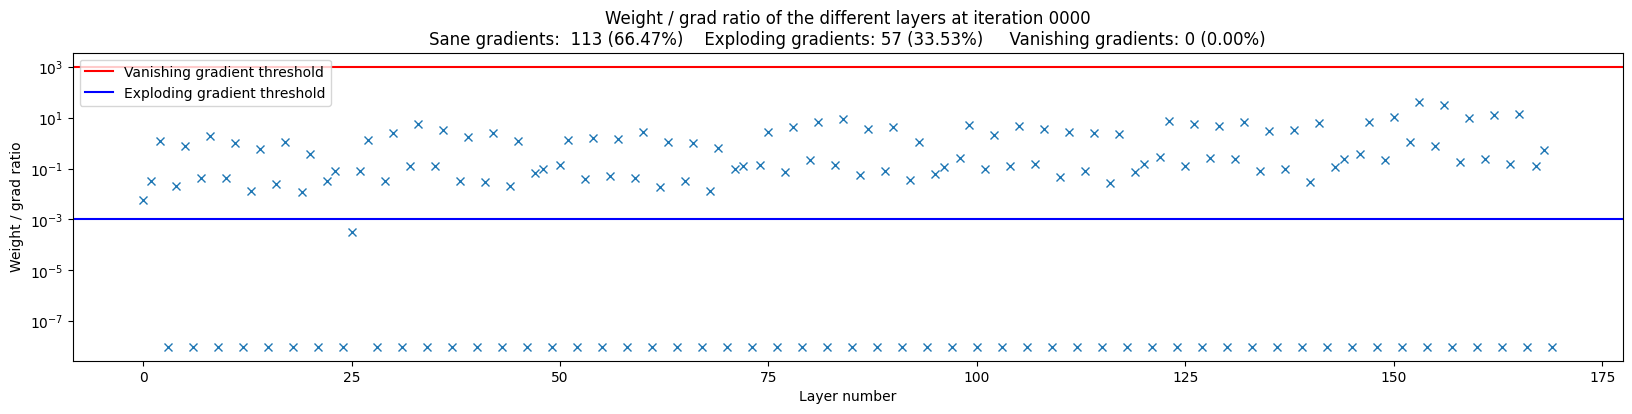

Epoch 0: 100%|██████████| 394/394 [02:50<00:00,  2.31it/s, v_num=54, val_loss=0.0184]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 394/394 [02:50<00:00,  2.31it/s, v_num=54, val_loss=0.0184]


In [5]:
trainer.fit(model, datamodule=data_module)

In [6]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 394/394 [00:39<00:00, 10.02it/s]


[{}]

In [7]:
model = UnrolledSystem.load_from_checkpoint(f'tb_logs/lightning_logs/version_{logger.version}/checkpoints/best.ckpt')
model.eval()

x = imread('images/val/3096.jpg') / 255
OP = cfa_operator(CFAS[0], x.shape, RGB_SPECTRAL_STENCIL, 'dirac')
y = OP.direct(x)
x_baseline = OP.adjoint(y)
input_data = torch.Tensor(y).to(DEVICE)[None]
mask = torch.Tensor(OP.cfa_mask).to(DEVICE).permute(2, 0, 1)
input_data = torch.cat([input_data, mask])[None]

with torch.no_grad():
    x_hat = np.clip(model(input_data)[-1][0].permute(1, 2, 0).numpy(force=True).astype(float), 0, 1)

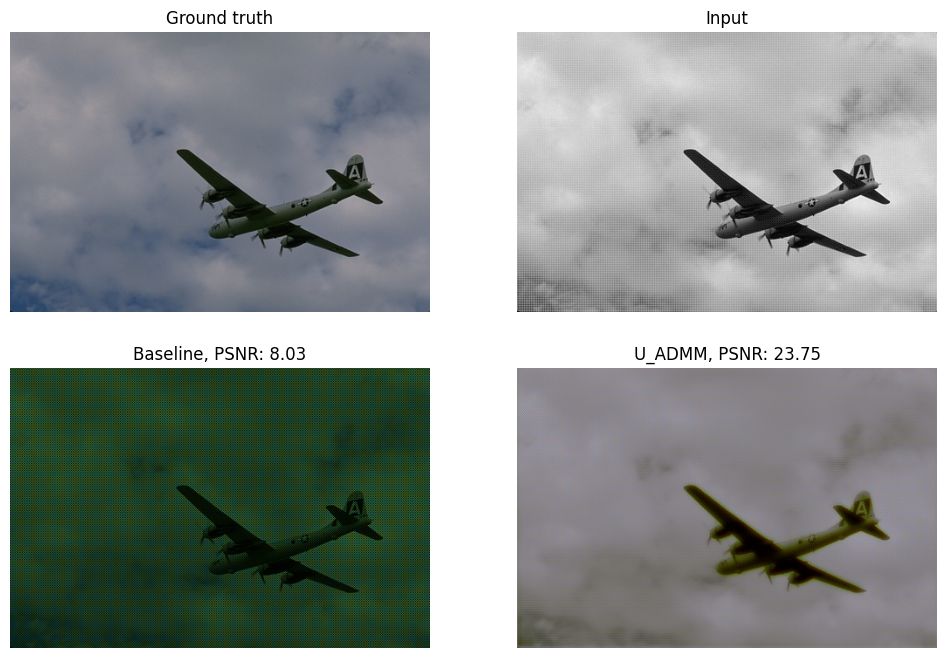

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 0].axis('off')
axs[0, 1].imshow(y, cmap='gray')
axs[0, 1].set_title('Input')
axs[0, 1].axis('off')
axs[1, 0].imshow(x_baseline)
axs[1, 0].set_title(f'Baseline, PSNR: {peak_signal_noise_ratio(x[2:-2, 2:-2], x_baseline[2:-2, 2:-2]):.2f}')
axs[1, 0].axis('off')
axs[1, 1].imshow(x_hat)
axs[1, 1].set_title(f'U_ADMM, PSNR: {peak_signal_noise_ratio(x[2:-2, 2:-2], x_hat[2:-2, 2:-2]):.2f}')
axs[1, 1].axis('off')
plt.show()